In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.impute import SimpleImputer
os.chdir('/home/sarthak/cornell/Krumsiek/')
import matplotlib.pyplot as plt

#this file focuses on implementing regression

In [2]:
# Load the Metabolomics data
metabolomics_file_path = 'UKBB_300K_Overlapping_MET.csv'
metabolomics_df = pd.read_csv(metabolomics_file_path, index_col=0)

# Load the Proteomics data (Olink)
proteomics_file_path = 'UKBB_300K_Overlapping_OLINK.csv'
proteomics_df = pd.read_csv(proteomics_file_path, index_col=0)


#turn to numpy array
met = metabolomics_df.to_numpy()
prot = proteomics_df.to_numpy()
print(met.shape, prot.shape)

#impute data using mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(prot)
prot = imp.transform(prot)

(27337, 251) (27337, 1461)


In [3]:
def z_score_normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean)/std

p = z_score_normalize(prot)
m = z_score_normalize(met)

In [4]:
#now we have the protein and metabolomic data, let's just do some simple multiple linear regression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(m, p, test_size=0.2, random_state=42)

#fit the model
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

MSE: 0.8630327732701719


In [5]:
print(y_pred.shape, y_test.shape)

(5468, 1461) (5468, 1461)


(1461,)


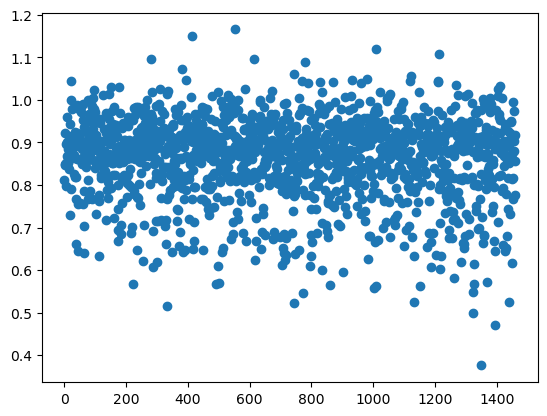

In [6]:
#now let's plot mse using the multioutput values
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print(mse.shape)

#now plot it
plt.scatter(range(0,len(mse)),mse)

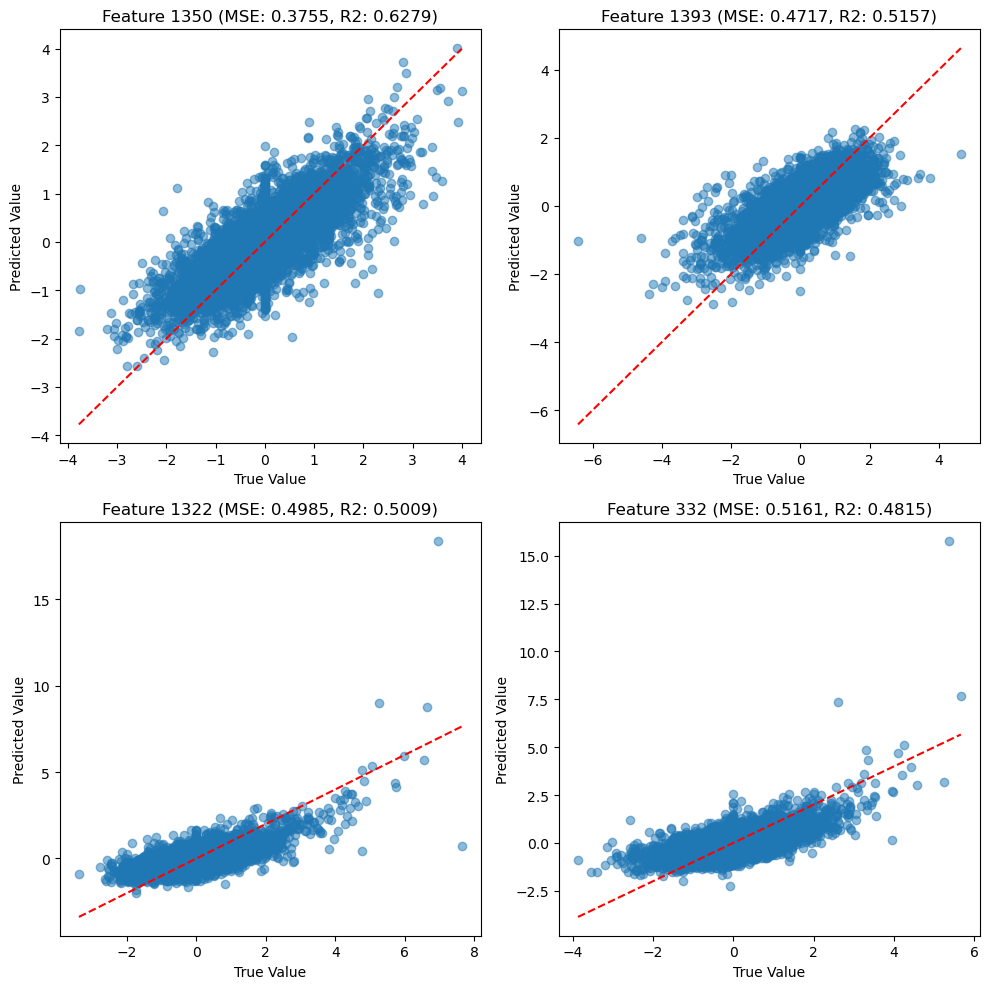

In [7]:
#now let's create scatter plots of the 4 proteins with the lowest mse

# Get the indices of the 4 features with the lowest MSE
lowest_mse_indices = np.argsort(mse)[:4]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i, feature_idx in enumerate(lowest_mse_indices):
    ax = axs[i]
    ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
    ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
            [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
            color='red', linestyle='--')
    R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
    ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

plt.tight_layout()
plt.show()

#unsure what proteins these are... but they are the ones with the lowest mse

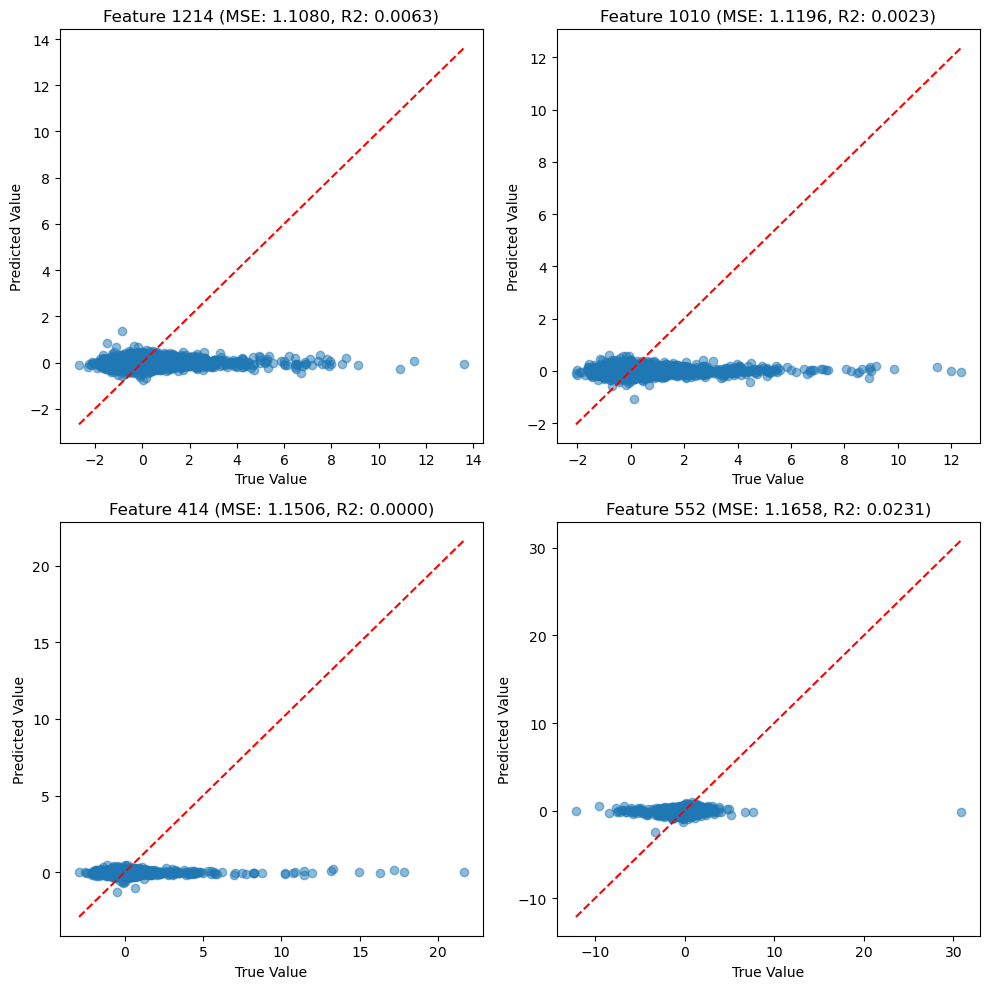

In [8]:
#and now look at the highest MSE

# Get the indices of the 4 features with the lowest MSE
lowest_mse_indices = np.argsort(mse)[-4:]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i, feature_idx in enumerate(lowest_mse_indices):
    ax = axs[i]
    ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
    ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
            [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
            color='red', linestyle='--')
    R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
    ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')

plt.tight_layout()
plt.show()

#literally no connection between the true and predicted values

In [9]:
def plot_fct(y_pred, y_test, mse_idx, mse):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    for i, feature_idx in enumerate(mse_idx):
        ax = axs[i]
        ax.scatter(y_test[:, feature_idx], y_pred[:, feature_idx], alpha=0.5)
        ax.plot([min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                [min(y_test[:, feature_idx]), max(y_test[:, feature_idx])],
                color='red', linestyle='--')
        R2 = np.corrcoef(y_test[:, feature_idx], y_pred[:, feature_idx])[0, 1] ** 2
        ax.set_title(f'Feature {feature_idx} (MSE: {mse[feature_idx]:.4f}, R2: {R2:.4f})')
        ax.set_xlabel('True Value')
        ax.set_ylabel('Predicted Value')

    plt.tight_layout()
    plt.show()

In [10]:
#now let's repeat the analysis with lasso regression
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

print(np.mean(mse))

0.9261727891982954


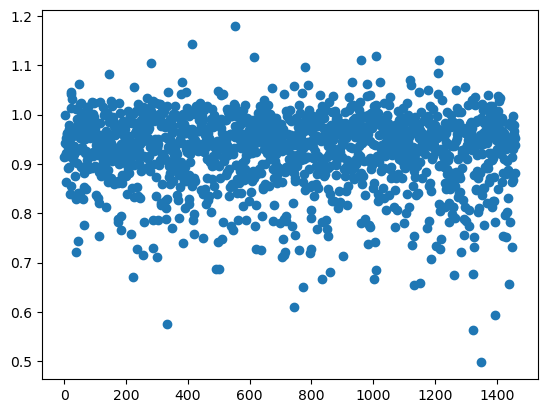

In [11]:
#once again scatter plot for mse
plt.scatter(range(0,len(mse)),mse)

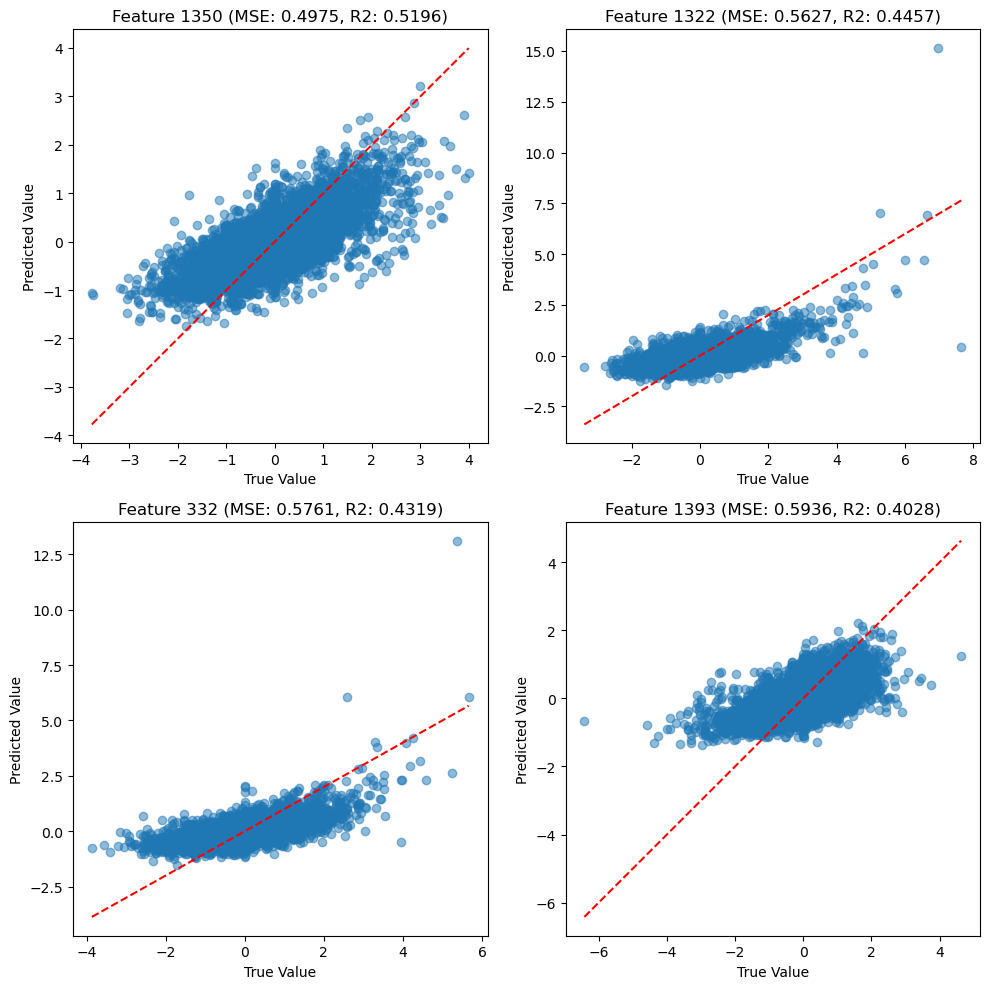

In [12]:
#now let's plot mse using the multioutput values
highest_mse = np.argsort(mse)[-4:]

lowest_mse = np.argsort(mse)[:4]

#now let's create scatter plots of the 4 proteins with the lowest mse
plot_fct(y_pred, y_test, lowest_mse, mse)

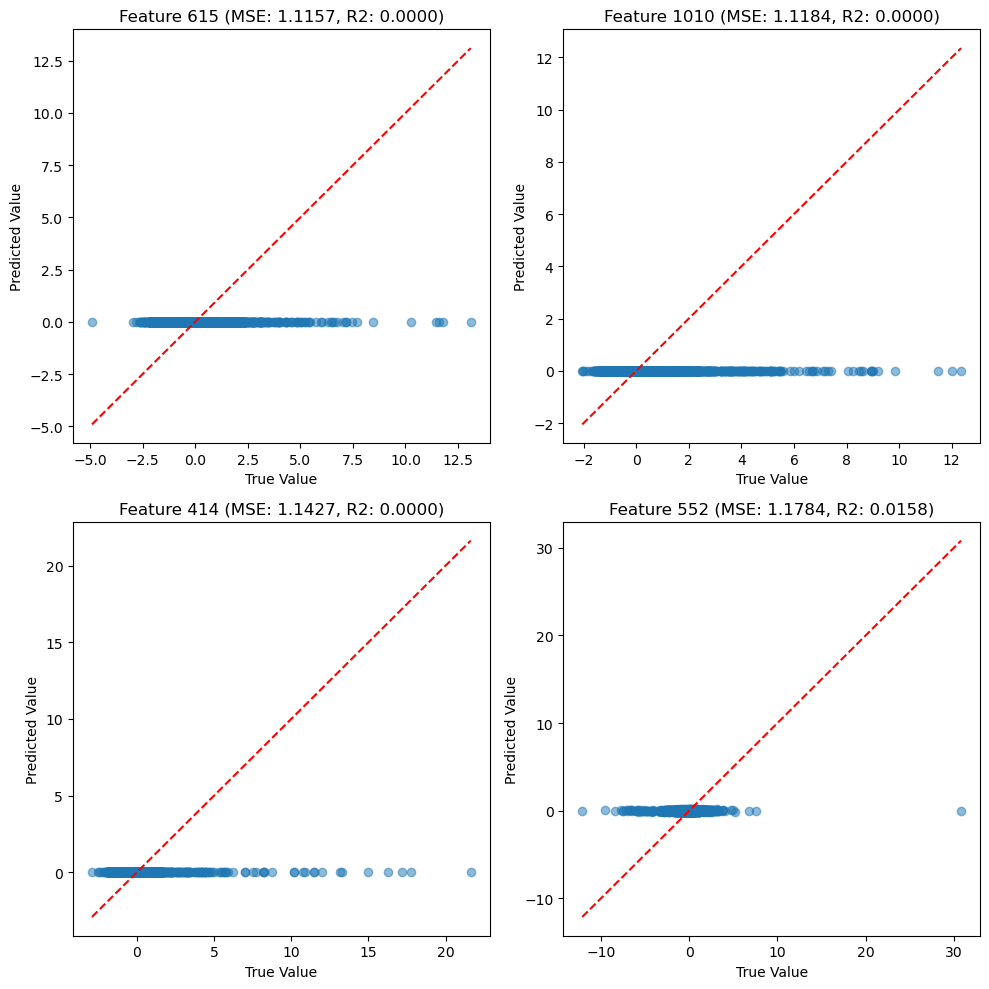

In [13]:
#highest mse values
plot_fct(y_pred, y_test, highest_mse, mse)

In [14]:
print(model.coef_.shape)
print(y_pred.shape) #same shape as y_test, 20% of the total data

#so the way this works is youw ant to multiply the metabolomics data by the coefficients to get the predicted proteomics data
#this is stored as W.T where we have the weights for each metabolite
#It says that W is the in cost function formula, but it means weights that minimize the cost function

#So, if we want to find the proteomics data from metabolomics data, it is 27000 x 251. Then W is 251 x 1461
#then we multiply it to get 27000 x 1461

#ypred = X*W.T + b, where b is the intercept and X is our input 27000 x 251
#linear transformation to each row of X to produce corresponding row of y_pred, each y_pred is linear combination of corresponding row of X
#so the first row is all the weights sused in the first row of X to get the first row of y_pred
#for each column, you take the first column of weights and then multiply it by all the rows of X to get the first column of y_pred

#so the first column of y_pred is going to be a linear combination of all the values of X where the lienar combination is set weights for
#each individual sample and it's the first column of W.T

#so the prediction when we have no intercept is just np.matmul(X_test, W.T)
#the intercept is the same length as y_pred, so we just add it to each row of y_pred. Each column gets own independent intercept
# y_pred = X_test @ W_T + b

(1461, 251)
(5468, 1461)


In [15]:
# #now let's try GLMnet, which is a combination of lasso and ridge regression
# from sklearn.linear_model import MultiTaskElasticNetCV
# model = MultiTaskElasticNetCV(l1_ratio=[.1, .5, .9, 1], alphas=np.logspace(-2, 2, 4), max_iter=1000, random_state=42)
# model.fit(X_train, y_train) #automatically finds the best alpha and l1 ratio that lowest the average mse

# #now predict
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred, multioutput='raw_values') #calculates mse for each row independently
# print(np.mean(mse))

In [16]:
#let's just do elastic net regression
from sklearn.linear_model import MultiTaskElasticNet
model = MultiTaskElasticNet(alpha=0.1, l1_ratio=0.9)
model.fit(X_train, y_train)

#now predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values') #calculates mse for each row independently
print(np.mean(mse))

0.8721967197072253


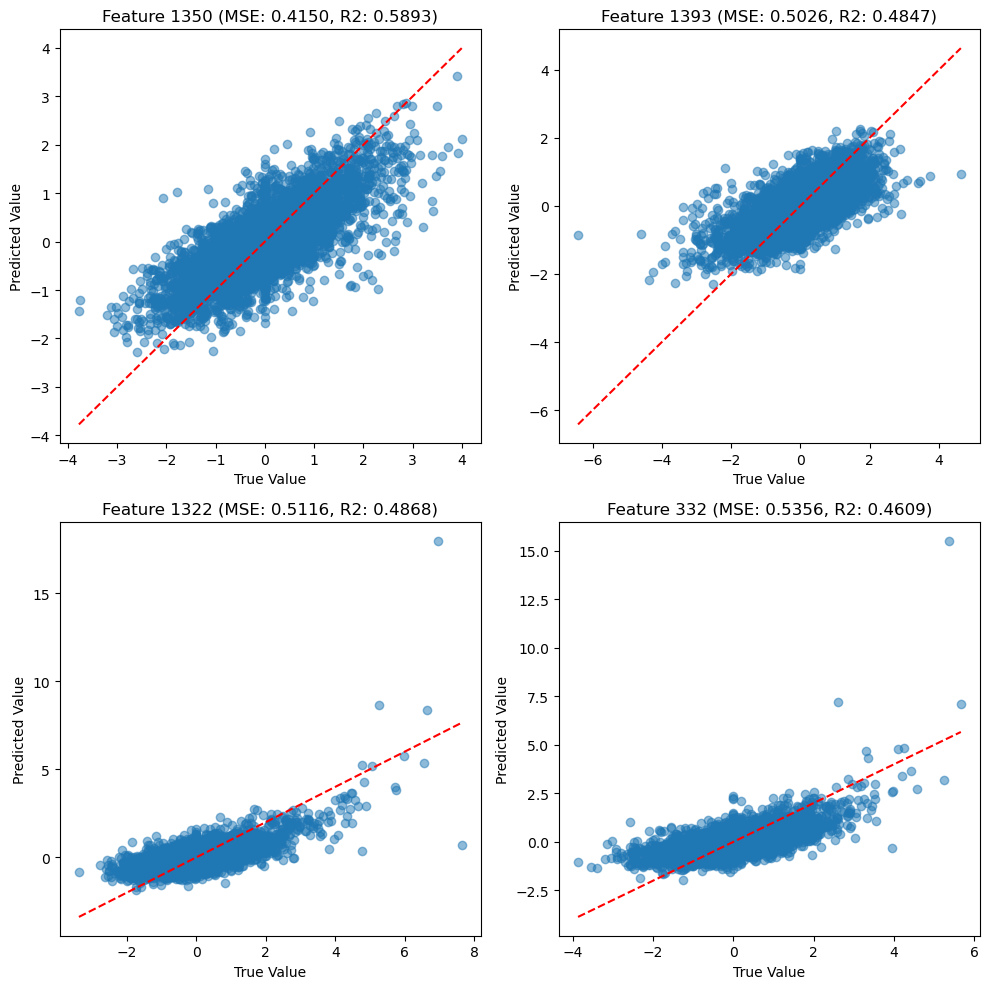

In [17]:
highest_mse = np.argsort(mse)[-4:]

lowest_mse = np.argsort(mse)[:4]

#now let's create scatter plots of the 4 proteins with the lowest mse
plot_fct(y_pred, y_test, lowest_mse, mse)

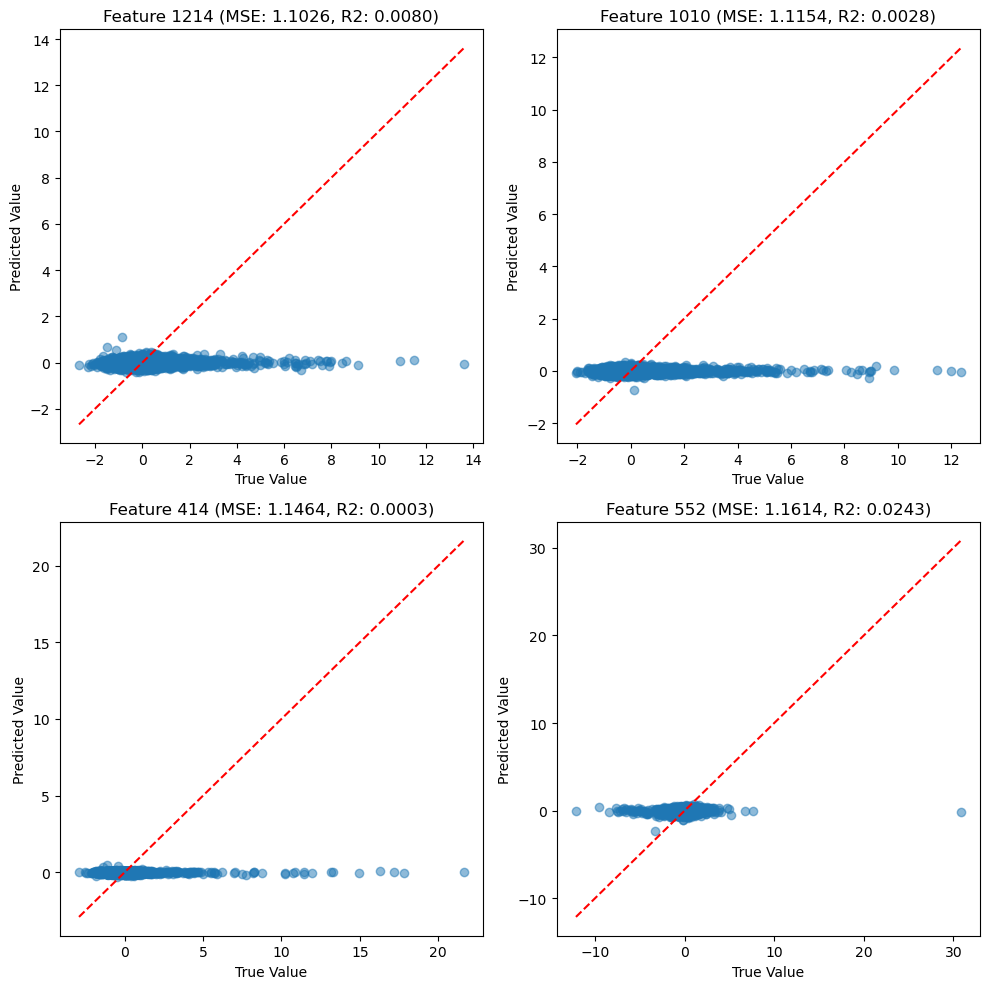

In [18]:
plot_fct(y_pred, y_test, highest_mse, mse)

In [19]:
#let's just do basic linear regression no penalty
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

#now predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values') #calculates mse for each row independently
print(np.mean(mse))

0.8668602246315279


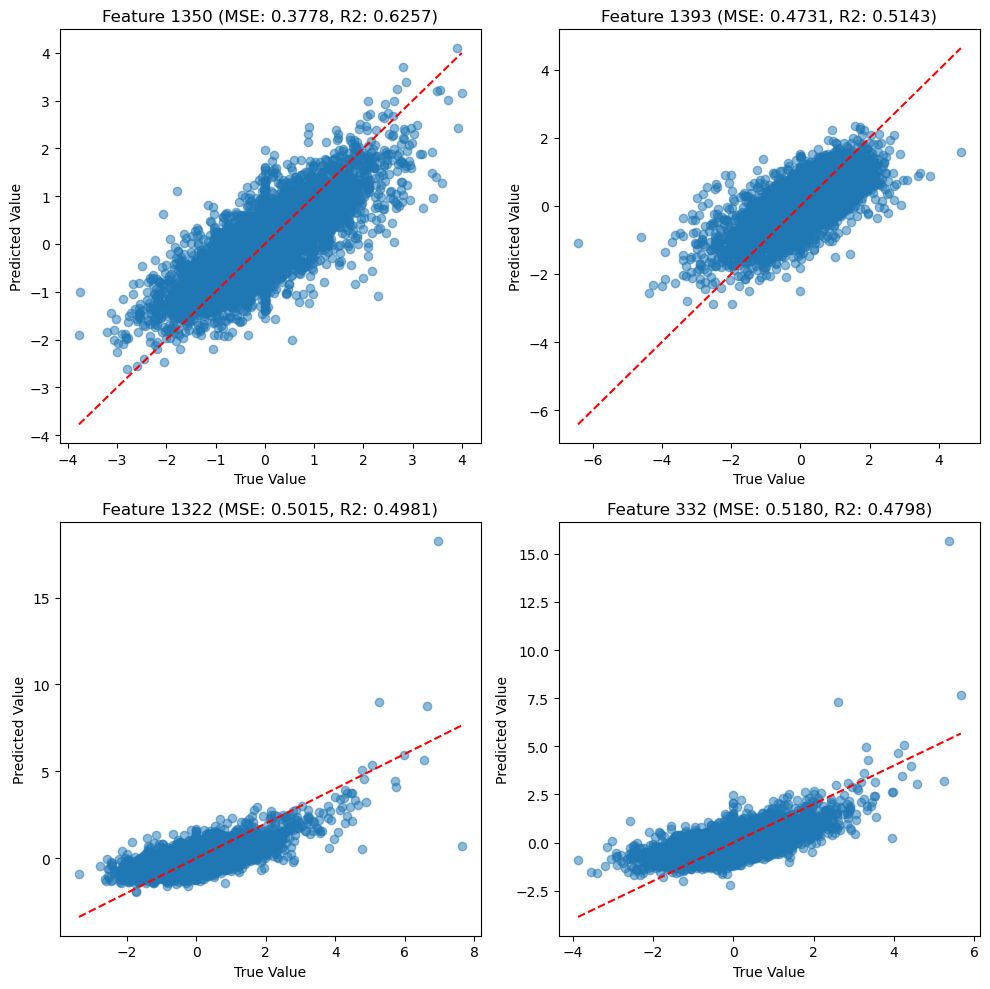

In [20]:
highest_mse = np.argsort(mse)[-4:]

lowest_mse = np.argsort(mse)[:4]

#now let's create scatter plots of the 4 proteins with the lowest mse
plot_fct(y_pred, y_test, lowest_mse, mse)

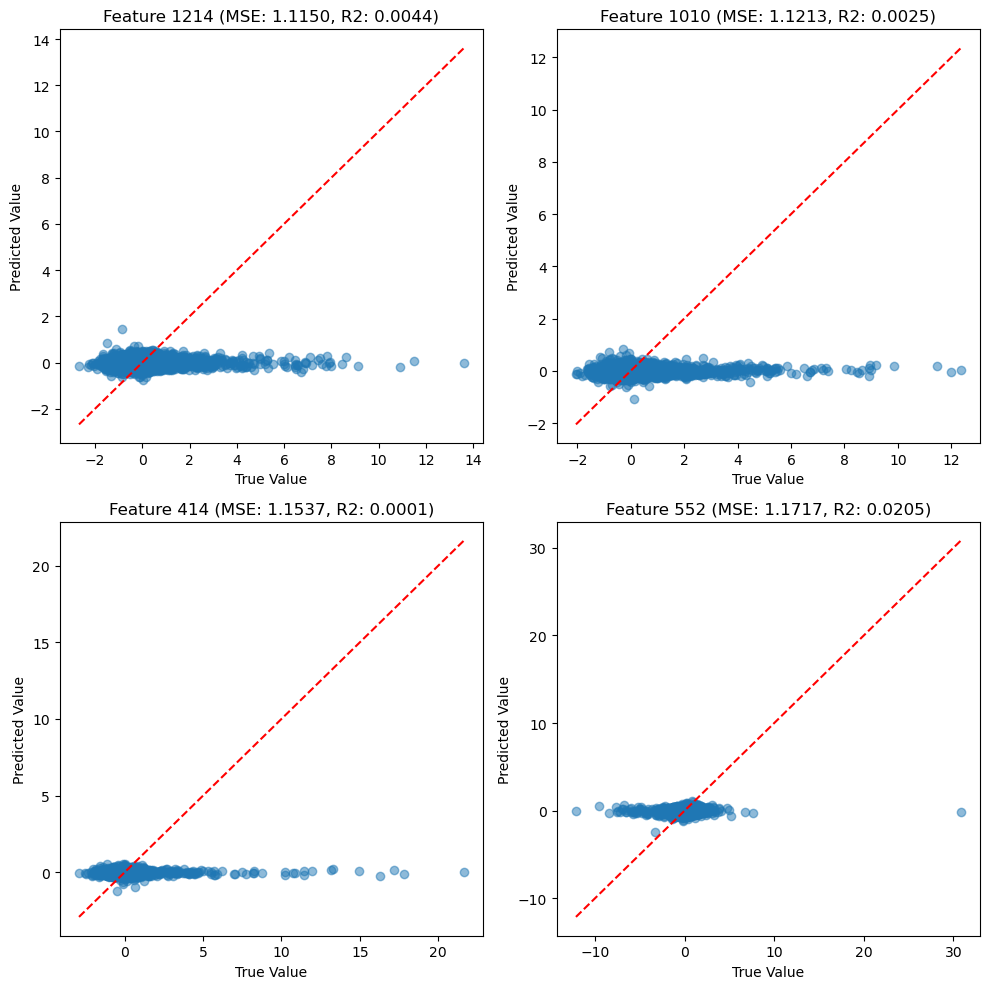

In [21]:
plot_fct(y_pred, y_test, highest_mse, mse)